In [2]:
pacman::p_load(ggplot2,dplyr,tidyr,data.table,stats,
               vegan,ggpubr,corrplot,Hmisc,GGally,mapproj,
               igraph,network, sna, wesanderson,dils,mapdata,
               RColorBrewer,data.table,dtplyr,cowplot,tibble,
               ggforce,ggnewscale,philentropy,ggdendro,
               ggplot2,dplyr,tidyr,data.table,igraph,ggnet)

## Functions related to the network analysis approach

In [37]:
## the final "full_taxonomy" file is the taxonomy generated by EUKulele and by 
## mmseqs combined together in order to capture accurate labels for groups
## to be used for colors in plotting
full_taxonomy=read.csv(file.path("..","input","eukulele_mmseqs_joined_tax.csv")) %>%
              dplyr::left_join(read.csv(file.path("..","input",
                                                  "eukulele_mmseqs_joined_tax_sarahgroups.csv"))) %>%
    dplyr::mutate(Genome=new_mag_name)

#' Copy the taxonomy and return whether a eukaryote or a prokaryote
#' and its taxonomy string.
# Author: Arianna Krinos ----------------
get_euk_prok <- function(genome_names) {
    modified_df = data.frame(Genome = genome_names) %>% 
        dplyr::left_join(full_taxonomy, by = c("Genome")) %>%
        dplyr::mutate(EukOrProk = as.character(Domain)) %>%
        dplyr::mutate(EukOrProk = case_when(EukOrProk == "Eukaryota" ~ "euk",
                                            EukOrProk == "d__Bacteria" ~ "prok",
                                            TRUE ~ "unclass"))
    return(modified_df)
}


#' Copy the taxonomy and return whether a eukaryote or a prokaryote
#' and its taxonomy string.
# Author: Arianna Krinos ----------------
get_tax_string <- function(genome_names,cluster_groups=cluster_groups) {
    modified_df = data.frame(Genome = as.character(genome_names))%>% 
        dplyr::left_join(cluster_groups %>%
                         dplyr::distinct(Cluster, .keep_all = T),by=c("Genome"="Cluster")) %>%
        dplyr::mutate(Genome = case_when(is.na(Genome)|(grepl("Cluster",Genome)) ~ MAG,
                                          TRUE ~ Genome)) %>%
        dplyr::left_join(full_taxonomy, by = c("Genome")) %>%
        dplyr::mutate(EukOrProk = as.character(Domain_EUKulele)) %>%
        dplyr::mutate(EukOrProk = case_when(EukOrProk == "Eukaryota" ~ "euk",
                                            EukOrProk == "d__Bacteria" ~ "prok",
                                            TRUE ~ "unclass"))
    tax_cols = c("Domain_EUKulele","Supergroup_EUKulele",
                 "Phylum_EUKulele","Class_EUKulele",
                 "Order_EUKulele","Family_EUKulele","Genus_EUKulele","Species_EUKulele")
    modified_df = modified_df %>% unite("tax_combo", all_of(tax_cols), sep=";",remove = TRUE)
    return(modified_df$tax_combo)
}

get_tax_string_no_cluster <- function(genome_names) {
    modified_df = data.frame(Genome = genome_names) %>% 
        dplyr::left_join(full_taxonomy, by = c("Genome")) %>%
        dplyr::mutate(EukOrProk = as.character(Domain_EUKulele)) %>%
        dplyr::mutate(EukOrProk = case_when(EukOrProk == "Eukaryota" ~ "euk",
                                            EukOrProk == "d__Bacteria" ~ "prok",
                                            TRUE ~ "unclass"))
    tax_cols = c("sarah_groups","Domain_EUKulele","Supergroup_EUKulele","Phylum_EUKulele",
                 "Class_EUKulele",
                 "Order_EUKulele","Family_EUKulele","Genus_EUKulele","Species_EUKulele")
    modified_df = modified_df %>% unite("tax_combo", all_of(tax_cols), sep=";",remove = TRUE)
    return(modified_df$tax_combo)
}

#' Combine the cluster names and sort them so that we don't have duplicates based on cluster
#' member ordering.
#' Author: Arianna Krinos -----------------
get_combo <- function(df_graph) { 
    combined_clust = c()
    for (i in c(1:length(df_graph$from))) {
        combined_clust = c(combined_clust,paste(sort(c(df_graph$from[i],df_graph$to[i])),collapse="_"))
    }
    return(combined_clust)
}

Joining, by = c("Domain_EUKulele", "Supergroup_EUKulele",
"Phylum_EUKulele", "Class_EUKulele", "Order_EUKulele",
"Family_EUKulele", "Genus_EUKulele", "Species_EUKulele",
"harriet_groups", "Kingdom_mmseqs", "Clade_mmseqs",
"Phylum_mmseqs", "Class_mmseqs", "subclass", "Order_mmseqs",
"Family_mmseqs", "Genus_mmseqs", "Species_mmseqs")


## Read in TPM-derived correlations from Python code `network-analysis`

In [5]:
combined_graph_tpm = data.frame(fread(file.path("/vortexfs1/omics/alexander/akrinos/2021-03_Tara/tara-networks/code/combined_graph_tpm_fullpval.csv")))
combined_graph_tpm = combined_graph_tpm[combined_graph_tpm$pval < (1-(1-0.05)**(1/nrow(combined_graph_tpm))),]

## Run if you don't have a copy of `../input/igraph_dataframe_new_tpm.csv`

In [ ]:
for_igraph = combined_graph_tpm[,colnames(combined_graph_tpm) %in% c("mag1","mag2","corrcoef")]

In [ ]:
for_igraph = combined_graph_tpm[,colnames(combined_graph_tpm) %in% c("mag1","mag2","corrcoef")]
for_igraph$Link = ""
translation_dict = read.csv(file.path("..","input","renamed-eukaryotic-mags.tsv"), sep='\t') %>%
    dplyr::bind_rows(read.csv(file.path("..","input","renamed-prokaryotic-mags.tsv"), sep='\t'))
full_taxonomy = full_taxonomy %>% dplyr::left_join(translation_dict,
                                                   by = c("Genome"="old_mag_name")) %>%
    dplyr::filter(!is.na(Genome)) %>% dplyr::rename(old_mag_name=Genome,Genome=new_mag_name)
modified_df = data.frame(Genome = for_igraph$mag1) %>% 
        dplyr::left_join(full_taxonomy %>% dplyr::distinct(Genome,.keep_all=TRUE), by = c("Genome")) %>%
        dplyr::mutate(EukOrProk = as.character(Domain)) %>%
        dplyr::mutate(EukOrProk = case_when(EukOrProk == "Eukaryota" ~ "euk",
                                            EukOrProk == "d__Bacteria" ~ "prok",
                                            TRUE ~ "unclass"))
modified_df2 = data.frame(Genome = for_igraph$mag2) %>% 
        dplyr::left_join(full_taxonomy %>% dplyr::distinct(Genome,.keep_all=TRUE), by = c("Genome")) %>%
        dplyr::mutate(EukOrProk = as.character(Domain)) %>%
        dplyr::mutate(EukOrProk = case_when(EukOrProk == "Eukaryota" ~ "euk",
                                            EukOrProk == "d__Bacteria" ~ "prok",
                                            TRUE ~ "unclass"))

for_igraph = for_igraph %>%
    dplyr::mutate(Dom1=as.character(modified_df$EukOrProk),
                  Dom2=as.character(modified_df2$EukOrProk))

for_igraph = for_igraph %>% dplyr::mutate(Link = case_when((Dom1 == "prok") & (Dom2 == "euk") ~ "Euk-Prok",
                                               (Dom2 == "prok") & (Dom1 == "euk") ~ "Euk-Prok",
                                               (Dom1 == "prok") & (Dom2 == "prok") ~ "Prok-Prok",
                                               (Dom1 == "euk") & (Dom2 == "euk") ~ "Euk-Euk",
                                               TRUE ~ "Other"))
write.csv(for_igraph,file.path("..","input","igraph_dataframe_new_tpm.csv"))

## Run this code every time you restart the notebook

In [6]:
for_igraph = read.csv(file.path("..","input","igraph_dataframe_new_tpm.csv"))

## Filter based on BUSCO completeness

In [7]:
##### FILTER CANDIDATES BASED ON BUSCO COMPLETENESS #####
translation_dict = read.csv(file.path("..","input",'renamed-eukaryotic-mags.tsv'), sep='\t')
busco_completeness = data.frame(fread(file.path("..","input","EUK_BUSCO_CC.csv"))) %>%
    dplyr::left_join(translation_dict,by=c("V1"="old_mag_name"))
for_igraph_buscofilt = for_igraph %>% dplyr::left_join(busco_completeness, by = c("mag1" = "new_mag_name")) %>%
    dplyr::left_join(busco_completeness, by = c("mag2" = "new_mag_name")) %>%
    dplyr::filter((Completeness.x > 30) | (is.na(Completeness.x))) %>%
    dplyr::filter((Completeness.y > 30) | (is.na(Completeness.y))) 

## Note: we have already filtered by ANI in the revised process for undergoing `coverm`. This is detailed in the `dereplication-and-abundance.ipynb` notebook in this folder.

In [18]:
for_igraph_buscofilt_all = for_igraph_buscofilt %>%
    dplyr::rename(c("from"="mag1","to"="mag2"))

for_igraph_buscofilt = for_igraph_buscofilt %>% dplyr::filter((Link == "Euk-Prok") | (Link == "Euk-Euk")) %>%
    dplyr::rename(c("from"="mag1","to"="mag2"))

In [38]:
reclustered_network = for_igraph_buscofilt %>% 
    dplyr::mutate("Classifications_from" = get_tax_string_no_cluster(for_igraph_buscofilt$from)) %>%
    dplyr::mutate("Classifications_to" = get_tax_string_no_cluster(for_igraph_buscofilt$to)) %>%
    separate(Classifications_to, sep = ";", fill = "left",
                    paste0(c("sarah_groups","Domain","Clade","Kingdom","Supergroup","Phylum","Class",
                 "Order","Family","Genus","Species"),"_to")) %>%
    separate(Classifications_from, sep = ";", fill = "left",
                    paste0(c("sarah_groups","Domain","Clade","Kingdom","Supergroup","Phylum","Class",
                 "Order","Family","Genus","Species"),"_from")) %>%
    dplyr::mutate(Cluster_From=from,Cluster_To=to) %>%
    dplyr::mutate(from = case_when(grepl("Cluster", Cluster_From) ~ Cluster_From,
                                   TRUE ~ from)) %>%
    dplyr::mutate(to = case_when(grepl("Cluster", Cluster_To) ~ Cluster_To,
                                   TRUE ~ to)) %>%
    dplyr::filter(corrcoef > 0.5) %>%
    dplyr::filter(from != to) 
reclustered_network$Domain_to[is.na(reclustered_network$Domain_to)] = "Bacteria"
reclustered_network$Domain_from[is.na(reclustered_network$Domain_from)] = "Bacteria"

reclustered_network_allconnections = for_igraph_buscofilt_all %>% 
    dplyr::mutate("Classifications_from" = get_tax_string_no_cluster(for_igraph_buscofilt_all$from)) %>%
    dplyr::mutate("Classifications_to" = get_tax_string_no_cluster(for_igraph_buscofilt_all$to)) %>%
    separate(Classifications_to, sep = ";", fill = "left",
                    paste0(c("Domain","Clade","Kingdom","Supergroup","Phylum","Class",
                 "Order","Family","Genus","Species"),"_to")) %>%
    separate(Classifications_from, sep = ";", fill = "left",
                    paste0(c("Domain","Clade","Kingdom","Supergroup","Phylum","Class",
                 "Order","Family","Genus","Species"),"_from")) %>%
    dplyr::mutate(Cluster_From=from,Cluster_To=to) %>%
    dplyr::mutate(from = case_when(grepl("Cluster", Cluster_From) ~ Cluster_From,
                                   TRUE ~ from)) %>%
    dplyr::mutate(to = case_when(grepl("Cluster", Cluster_To) ~ Cluster_To,
                                   TRUE ~ to)) %>%
    dplyr::filter(from != to) 
reclustered_network_allconnections$Domain_to[is.na(reclustered_network_allconnections$Domain_to)] = "Bacteria"
reclustered_network_allconnections$Domain_from[is.na(reclustered_network_allconnections$Domain_from)] = "Bacteria"


## Now let's generate our actual network figures

IGRAPH 2e65a6e UN-- 549 6417 -- 
+ attr: name (v/c), clustermembership (v/n), corrcoef (e/n), Link
| (e/c), Dom1 (e/c), Dom2 (e/c), combined_clust (e/c)
+ edges from 2e65a6e (vertex names):
 [1] TOPAZ_SPS4_E052--TOPAZ_SPS4_E010 TOPAZ_SPS3_E064--TOPAZ_NPS4_E003
 [3] TOPAZ_NPS1_E017--TOPAZ_IOS1_E029 TOPAZ_SPS3_E018--TOPAZ_NAS3_E002
 [5] TOPAZ_SPS1_E084--TOPAZ_SPS1_E029 TOPAZ_SAS3_E005--TOPAZ_SAD3_E001
 [7] TOPAZ_SPS3_E081--TOPAZ_SPS3_E035 TOPAZ_SAS3_E014--TOPAZ_NAS3_E009
 [9] TOPAZ_SPS3_E018--TOPAZ_SPS3_E077 TOPAZ_SPS3_E077--TOPAZ_NAS3_E002
[11] TOPAZ_SPS3_E055--TOPAZ_SPS3_E014 TOPAZ_NPS1_E006--TOPAZ_SPS1_E029
[13] TOPAZ_SPS3_E018--TOPAZ_MSS2_E008 TOPAZ_SPS3_E082--TOPAZ_SAD3_E001
+ ... omitted several edges

IGRAPH 2e65a6e UN-- 549 6417 -- 
+ attr: name (v/c), classification (v/c), corrcoef (e/n), Link (e/c),
| Dom1 (e/c), Dom2 (e/c), combined_clust (e/c)
+ edges from 2e65a6e (vertex names):
 [1] TOPAZ_SPS4_E052--TOPAZ_SPS4_E010 TOPAZ_SPS3_E064--TOPAZ_NPS4_E003
 [3] TOPAZ_NPS1_E017--TOPAZ_IOS1_E029 TOPAZ_SPS3_E018--TOPAZ_NAS3_E002
 [5] TOPAZ_SPS1_E084--TOPAZ_SPS1_E029 TOPAZ_SAS3_E005--TOPAZ_SAD3_E001
 [7] TOPAZ_SPS3_E081--TOPAZ_SPS3_E035 TOPAZ_SAS3_E014--TOPAZ_NAS3_E009
 [9] TOPAZ_SPS3_E018--TOPAZ_SPS3_E077 TOPAZ_SPS3_E077--TOPAZ_NAS3_E002
[11] TOPAZ_SPS3_E055--TOPAZ_SPS3_E014 TOPAZ_NPS1_E006--TOPAZ_SPS1_E029
[13] TOPAZ_SPS3_E018--TOPAZ_MSS2_E008 TOPAZ_SPS3_E082--TOPAZ_SAD3_E001
+ ... omitted several edges

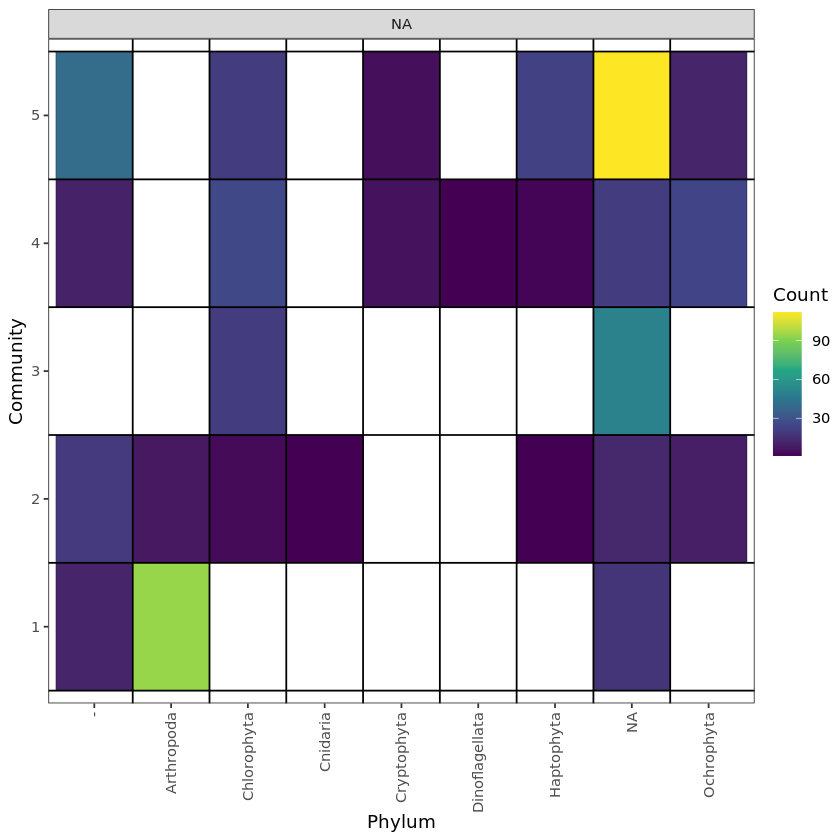

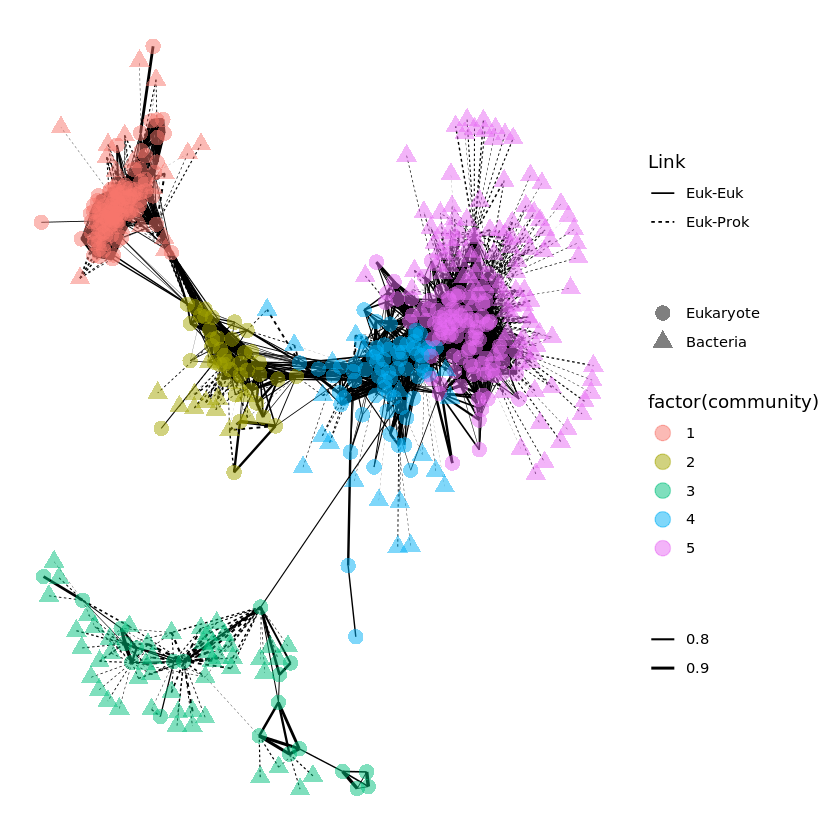

In [31]:
##### GENERATE GRAPH FROM THE REFACTORED NETWORK #####
df_graph <- reclustered_network %>% 
            dplyr::select(to,from,corrcoef,Link,Dom1,Dom2)%>%
            dplyr::filter(corrcoef > 0.7) %>%
            arrange(desc(corrcoef)) %>%
            dplyr::distinct(to,from,Link,Dom1,Dom2,.keep_all=TRUE)
df_graph$combined_clust = get_combo(df_graph)
df_graph <- df_graph %>% dplyr::distinct(combined_clust,.keep_all=TRUE)
refactored_graph <- graph_from_data_frame(df_graph,
                                          directed = FALSE, vertices = NULL)

corr_communities <- cluster_louvain(refactored_graph,weight=df_graph$corrcoef)

set_vertex_attr(refactored_graph, "clustermembership",
                index = V(refactored_graph),
                membership(corr_communities))
set_vertex_attr(refactored_graph, "classification",
                index = V(refactored_graph),
                get_tax_string_no_cluster(V(refactored_graph)$name))

edge_df <- df_graph

# Create a layout of the graph
layout_gr <- as.data.frame(layout.fruchterman.reingold(refactored_graph))
# Add the MAG labels
layout_gr$mag <- V(refactored_graph)$name

# Add the euk-prok labels
edge_df_inform <- edge_df %>% dplyr::select(from,Dom1) %>% dplyr::rename(c("mag"="from","class"="Dom1")) %>%
                    dplyr::bind_rows(edge_df %>% dplyr::select(to,Dom2) %>% 
                                     dplyr::rename(c("mag"="to","class"="Dom2")))
layout_gr$eukprok <- edge_df_inform$class[match(layout_gr$mag,edge_df_inform$mag)]
layout_gr$classification <- get_tax_string_no_cluster(layout_gr$mag)
layout_gr$community <- membership(corr_communities)
# manually re-assign communities so we don't have to re-label them after changing
# ANI cutoff
layout_gr_manual = layout_gr %>% dplyr::mutate(community = case_when(community == 1 ~ 1,
                                                                     community == 2 ~ 3,
                                                                     community == 3 ~ 2,
                                                                     community == 4 ~ 5,
                                                                     community == 5 ~ 4,
                                                                     TRUE ~ as.numeric(community) + 10))

layout_gr<-layout_gr_manual
layout_gr <- layout_gr %>% 
                    dplyr::mutate("degree" = as.numeric(as.character(igraph::degree(refactored_graph,
                                                                                  v = layout_gr$mag))))

large_communities = unique((layout_gr %>% dplyr::distinct(mag,community,.keep_all=TRUE) %>%
    dplyr::group_by(community) %>% dplyr::tally() %>%
    dplyr::filter(n > 3))$community)
layout_gr = layout_gr %>% #dplyr::left_join(cluster_groups,by=c("mag"="Cluster")) %>% 
            #dplyr::mutate(classification = case_when((classification.x == "none") ~ classification.y,
            #                                         TRUE ~ classification.x)) %>%
            dplyr::select(V1,V2,eukprok,mag,classification,community,degree) %>%
   #dplyr::filter(degree > 0) %>%
   dplyr::filter(community %in% large_communities)
   
edge_df = edge_df %>% dplyr::filter((to %in% layout_gr$mag) & (from %in% layout_gr$mag))
layout_gr <- layout_gr %>% dplyr::distinct()

edge_df$from.x <- layout_gr$V1[match(edge_df$from, layout_gr$mag)]  #  match the from locations from the node data.frame we previously connected
edge_df$from.y <- layout_gr$V2[match(edge_df$from, layout_gr$mag)]
edge_df$to.x <- layout_gr$V1[match(edge_df$to, layout_gr$mag)]  #  match the to locations from the node data.frame we previously connected
edge_df$to.y <- layout_gr$V2[match(edge_df$to, layout_gr$mag)]

layout_gr_classes = layout_gr %>% 
    separate(classification, sep = ";", fill = "left",
                    c("Domain","Clade","Kingdom","Supergroup",
                      "Phylum","Class","Order","Family","Genus","Species"))

##### VISUALIZE TAXONOMIC CLASSES IN EACH COMMUNITY #####
taxon_comm = ggplot(layout_gr_classes) + stat_bin2d(aes(x = Phylum, y = factor(community), fill = after_stat(count)),
                                       colour="black") + 
    facet_wrap(~Domain,scales="free_x") + theme_test() + 
    scale_fill_continuous(na.value = "white", type="viridis", name = "Count") + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    geom_vline(xintercept=seq(1.5, length(unique(layout_gr_classes$Phylum))-0.5, 1), 
             lwd=0.5, colour="black") + 
    geom_hline(yintercept=seq(0.5, length(unique(layout_gr_classes$community))+0.5, 1), 
             lwd=0.5, colour="black") + 
    ylab("Community") + xlab("Phylum")
taxon_comm
#ggsave(file.path("..","si-figures","network_70cutoff_phylum.png"),
#       dpi=300, width = 6, height = 4, units = "in")

##### PLOT THE NETWORK COMMUNITIES #####
# this is adapted from here https://chrischizinski.github.io/rstats/igraph-ggplotll/
# Plot out the initial layout
n <- length(corr_communities)
palette <- c("#ea8cff","#01a24b","#ec1d92","#998400","#27a3ff",
             "#ff455e","#205297","#ffa56d","#764164","#b5706d","yellow")

network_plot = ggplot() +
    geom_segment(data=edge_df,aes(x=from.x,xend = to.x,y=from.y,
                                  yend = to.y,size=corrcoef,lty=Link),colour="black") +
        geom_point(data=layout_gr,aes(x=V1,y=V2,shape=factor(eukprok),
                                      colour=factor(community)),size=4,alpha=0.5) +
        theme_bw() +
        scale_shape(name = "", solid = TRUE, breaks = c("euk","prok"), labels = c("Eukaryote","Bacteria")) + 
        #scale_color_manual(name = "Community", values = palette) + 
        scale_size(range = c(0, 1),labels=c("0.6","0.7","0.8","0.9"),
                   breaks=c(0.6,0.7,0.8,0.9),name="") + 
        theme(
          axis.text.x = element_blank(),  # remove x-axis text
          axis.text.y = element_blank(), # remove y-axis text
          axis.ticks = element_blank(),  # remove axis ticks
          axis.title.x = element_blank(), # remove x-axis labels
          axis.title.y = element_blank(), # remove y-axis labels
          panel.background = element_blank(), 
          panel.border =element_blank(), 
          panel.grid.major = element_blank(),  #remove major-grid labels
          panel.grid.minor = element_blank(),  #remove minor-grid labels
          plot.background = element_blank())# + xlim(c(-10,30))+ ylim(c(-10,30))
    network_plot

In [35]:
colnames(reclustered_network)

[1] "X"               "to"              "from"            "corrcoef"       
 [5] "Link"            "Dom1"            "Dom2"            "V1.x"           
 [9] "Completeness.x"  "Contamination.x" "V1.y"            "Completeness.y" 
[13] "Contamination.y" "Domain_from"     "Clade_from"      "Kingdom_from"   
[17] "Supergroup_from" "Phylum_from"     "Class_from"      "Order_from"     
[21] "Family_from"     "Genus_from"      "Species_from"    "Domain_to"      
[25] "Clade_to"        "Kingdom_to"      "Supergroup_to"   "Phylum_to"      
[29] "Class_to"        "Order_to"        "Family_to"       "Genus_to"       
[33] "Species_to"      "Cluster_From"    "Cluster_To"